<a href="https://colab.research.google.com/github/JohnVicke/deep-learning/blob/main/viktor_malmedal_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN_Laboration

```
Author: Viktor Malmedal
Mail:   viktormalmedal@gmail.com
umuId:  vima0068
```

CNN laboration analyzing 4 different models with different parameters/layers that are trained on the MNIST fashion data set.


In [ ]:
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

import tensorflow.keras 
print(f'Keras version:      {tensorflow.keras.__version__}')

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.7.0
Keras version:      2.7.0


In [ ]:
import sys
if not tf.config.list_physical_devices('GPU'):
    print('No GPU detected. CNNs can be very slow without a GPU')
    if 'google.colab' in sys.modules:
        print('Go to RunTime > change runtime and select a GPU hardware accelerator')
else:
    !nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-99d7f4ed-c930-e79c-b772-8c60b273c10b)


In [ ]:
def split_random(data, labels, percent_train=80):
    print('Splitting data into training and validation')
    print(f'Training split     = {percent_train}%')
    print(f'Validation split   = {100-percent_train}%')
    indicies = np.arange(data.shape[0])

    for _ in range(4): 
        indicies = np.random.permutation(indicies)

    
    labels = labels[indicies]
    data = data[indicies]
    rows = data.shape[0]

    end_index = int(rows*percent_train/100)

    train_x = data[:end_index]
    train_y = labels[:end_index]

    validation_x = data[end_index:]
    validation_y = labels[end_index:]

    return (train_x, train_y), (validation_x, validation_y)

In [ ]:
def validate_data(data, labels, data_set_name):
    """
        Naive validation, only validets shape of data compared to labels
    """

    nr_images, x, y = data.shape
    print(f'\nRunning validation on {data_set_name}')
    print(f'Number of images   = {nr_images}')
    print(f'Number of labels   = {len(labels)}')
    print(f'Image dimension    = {x}x{y}')
    if nr_images != len(labels):
        print('Number of images does not match number of labels')
    else:
        print('Data is OK ✅')

In [ ]:
def get_class_dist(data):
    dist = {}
    for label in data:
        if label in dist:
            dist[label] += 1
        else:
            dist[label] = 1
    return dist


# Loading and visualising the data
- Splits the training data set into a training / validation split (80/20)%
- Runs a naive validation on all data sets to see if the length of labels and images are matching.
- Visualize the data.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
label_descriptions = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat',
                      'sandals', 'shirt', 'sneaker', 'bag', 'ankle boots']

(train_x, train_y), (validation_x, validation_y) = split_random(x_train, y_train)

# increase readability since i will use train_x, train_y from here on 
test_x = x_test
test_y = y_test
test_labels = y_test

validate_data(train_x, train_y, "training")
validate_data(validation_x, validation_y, "validation")
validate_data(test_x, test_y, "test")
distribution = get_class_dist(train_y)

print(f'\nTrain shape         = {train_x.shape}')
print(f'Validation shape    = {validation_x.shape}')
print(f'Test shape          = {x_test.shape}')
print(f'Unique labels       = {np.unique(train_y)}')
print('Label translation   = ---------------------')
for i, label in enumerate(label_descriptions):
    print(f'                     [{i}]: {label}')
print('Train distribution  = ---------------------')
for i, label in enumerate(label_descriptions):
    print('                     {:<20s}: {}'.format(label_descriptions[i], distribution[i]))
print('                     ---------------------')

4431872/4422102 [==============================] - 0s 0us/step
Splitting data into training and validation
Training split     = 80%
Validation split   = 20%

Running validation on training
Number of images   = 48000
Number of labels   = 48000
Image dimension    = 28x28
Data is OK ✅

Running validation on validation
Number of images   = 12000
Number of labels   = 12000
Image dimension    = 28x28
Data is OK ✅

Running validation on test
Number of images   = 10000
Number of labels   = 10000
Image dimension    = 28x28
Data is OK ✅

Train shape         = (48000, 28, 28)
Validation shape    = (12000, 28, 28)
Test shape          = (10000, 28, 28)
Unique labels       = [0 1 2 3 4 5 6 7 8 9]
Label translation   = ---------------------
                     [0]: t-shirt/top
                     [1]: trouser
                     [2]: pullover
                     [3]: dress
                     [4]: coat
                     [5]: sandals
                     [6]: shirt
                     [7]: sn

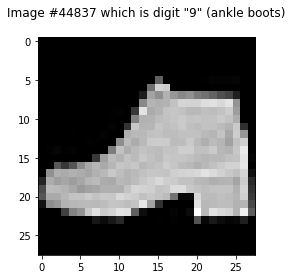

In [ ]:
from random import randrange
def plot_image(digit):
    plt.figure()
    plt.imshow(train_x[digit], cmap='gray', interpolation='nearest')
    plt.title(f'Image #{digit} which is digit "{train_y[digit]}" ({label_descriptions[train_y[digit]]})\n')
    plt.show(block=False)

ran_range = len(train_x) - 1
image_digits = [randrange(ran_range)]
plots = [plot_image(a) for a in image_digits]


<Figure size 432x288 with 0 Axes>

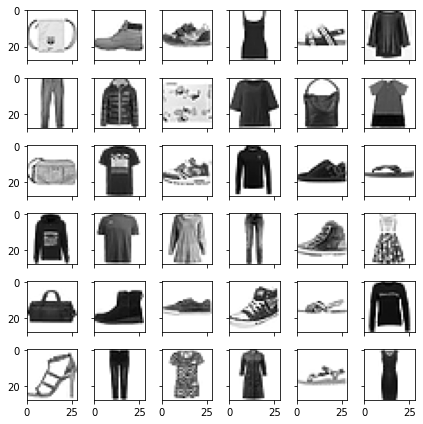

In [ ]:
from random import sample
ROWS = 6
random_indicies = sample(range(train_x.shape[0]), ROWS*ROWS)
sample_images = train_x[random_indicies, :]
plt.clf()
fig, axes = plt.subplots(ROWS, ROWS, 
                         figsize=(ROWS, ROWS),
                         sharex=True, sharey=True)

for i in range(ROWS*ROWS):
    subplot_row = i // ROWS
    subplot_col = i % ROWS
    ax = axes[subplot_row, subplot_col]
    plottable_image = np.reshape(sample_images[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

# Reshaping the data
- Normalize the images (0-255 grayscale into 0-1 float)
- Reshape into correct shape

In [ ]:
def reshape_data(data, img_width, img_height, channels_first):
    data = data.astype('float32') / 255.0

    if channels_first:
        data = data.reshape(data.shape[0], 1, img_width, img_height)
    else:
       data = data.reshape(data.shape[0], img_width, img_height, 1) 

    return data


In [ ]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [ ]:
def retrieve(mapping, *keys):
    return (mapping[key] for key in keys)

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Declaring global variables
nr_classes = len(np.unique(train_y))
_, img_width, img_height = train_x.shape
is_channels_first = backend.image_data_format() == 'channels_first'
input_shape = (1, img_width, img_height) if is_channels_first else (img_width, img_height, 1)

train_x = reshape_data(train_x, img_width, img_height, is_channels_first)
test_x = reshape_data(test_x, img_width, img_height, is_channels_first)
validation_x = reshape_data(validation_x, img_width, img_height, is_channels_first)

train_y = to_categorical(train_y, nr_classes)
test_y = to_categorical(test_y, nr_classes)
validation_y = to_categorical(validation_y, nr_classes)

training_data = (train_x, train_y)
validation_data = (validation_x, validation_y)
test_data = (test_x, test_y)

# CNN Model
Defines a CNNModel, storing values for the history/score and provides an easy interface to create new models that will all share a common training and testing strategy. Creating a new model requires a Sequential model in the constructor. This design decicion was made to simplify creating and analyzing different CNN models.

# Main charactaristics

- Using default batchsize (32)
- Running training in 15 epochs with an early stop callback for all models
    - Early stopping is using 3 in patience, which means that it can go back 3 iterations (epochs) and will choose the best weights that it has encountered if the models validation loss starts to increase instead of decreasing (diverging).
- Learning rate is reduced to decrease overfitting (0.001 seems to be a bit too fast in this scenario).
- Using adam as optimizer for adaptive learning rates (considered among the best, if not the best!)
- Using **categorical_crossentropy** for loss & **categorical_accuracy** for accuracy


### Note
```
I know that layers and models can be extended upon using subclasses, 
however I thought that this solution is adequate for the given assignment.
```

In [ ]:
class CNNModel():
    batch_size = 32
    epochs     = 15

    sequential = None
    stopped_at = None
    history    = None
    score      = None


    def __init__(self, sequential, name):
        self.name = name
        self.sequential = sequential
        self.stopped_at = self.epochs
        self.sequential.summary()

    def compile(self):
        optimizer = optimizers.Adam(learning_rate=0.0001)
        self.sequential.compile(loss='categorical_crossentropy',
                                optimizer=optimizer,
                                metrics=['categorical_accuracy'])
    
    def train(self, training_data, validation_data, verbose=1):
        early_stop_monitor = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        callbacks = [early_stop_monitor]
        train_x, train_y = training_data
        history = self.sequential.fit(train_x, train_y,
                                      batch_size=self.batch_size, 
                                      epochs=self.epochs,
                                      verbose=verbose,
                                      validation_data=validation_data,
                                      callbacks=callbacks)

        # Early stopped
        if early_stop_monitor.stopped_epoch != 0:
            self.stopped_at = early_stop_monitor.stopped_epoch

        self.history = history.history
    
    def evaluate(self, test_data):
        test_x, test_y = test_data
        score = self.sequential.evaluate(test_x, test_y)
        self.score = score

    def plot_history(self):
        train_loss, train_acc, val_loss, val_acc = retrieve(self.history, 
                                                            'loss',
                                                            'categorical_accuracy',
                                                            'val_loss',
                                                            'val_categorical_accuracy')
        early_stop_label = f'Stopped at {self.stopped_at}'
        epoch_range = range(1, self.stopped_at + 1)
        plt.plot(epoch_range, train_acc, 'bo', label='Training accuracy')
        plt.plot(epoch_range, val_acc, 'b', label='Validation accuracy')
        plt.title(f'Training and validation accuracy ({self.name})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.axvline(x=self.stopped_at, label=early_stop_label, color='k', ls='--')
        plt.legend()
        plt.show()

        plt.plot(epoch_range, train_loss, 'bo', color='red', label='Training loss')
        plt.plot(epoch_range, val_loss, 'b', color='red', label='Validation loss')
        plt.title(f'Training and validation loss ({self.name})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.axvline(x=self.stopped_at, label=early_stop_label, color='k', ls='--')
        plt.legend()
        plt.show()
        print()
    

# One layered simple CNN

In [ ]:
one_layer_cnn = Sequential([
    Conv2D(32, kernel_size=(3,3), 
           activation='relu', 
           input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])
one_layer_cnn_model = CNNModel(one_layer_cnn, 'One layer CNN with 3x3 kernel size')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 128)               692352    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                        

# One layered CNN with a 6x6 kernel size

In [ ]:
seq_6x6 = Sequential([
    Conv2D(32, kernel_size=(6,6), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])

seq_6x6_model = CNNModel(seq_6x6, 'One layered CNN with 6x6 kernel')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 23, 23, 32)        1184      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 3872)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               495744    
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                      

# Two layered CNN

In [ ]:
two_layer_cnn = Sequential([
    Conv2D(32, kernel_size=(3,3), 
           activation='relu', 
           input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2), padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax')
])
two_layered_cnn_model = CNNModel(two_layer_cnn, 'Two layered CNN model with 3x3 kernel')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 6, 6, 64)         

# Complex multilayered CNN

In [ ]:
complex_cnn = Sequential([

    Conv2D(32, kernel_size=(3,3), padding='same', 
           activation='relu',
           input_shape=input_shape),
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax'),
])
complex_cnn_model = CNNModel(complex_cnn, 'Complex multilayered CNN')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 64)       

In [ ]:
models = [one_layer_cnn_model, 
          two_layered_cnn_model,
          seq_6x6_model,
          complex_cnn_model]

In [ ]:
import time
print(f'Starting to train all {len(models)} models....')
global_start_time = time.time()
for model in models:
    print(f'Begin training model: {model.name}')
    start_time = time.time();
    model.compile()
    model.train(training_data, validation_data)
    elapsed_time = time.time() - start_time
    print(f'Training finished for :{model.name} in {hms_string(elapsed_time)}\n')

global_elapsed_time = time.time() - global_start_time
print()
print(f'Finisihed training all {len(models)} model(s) in {hms_string(global_elapsed_time)}')

Starting to train all 4 models....
Begin training model: One layer CNN with 3x3 kernel size
Epoch 1/15
1500/1500 [==============================] - 40s 6ms/step - loss: 0.5909 - categorical_accuracy: 0.8027 - val_loss: 0.4214 - val_categorical_accuracy: 0.8564
Epoch 2/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3990 - categorical_accuracy: 0.8607 - val_loss: 0.3751 - val_categorical_accuracy: 0.8727
Epoch 3/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3580 - categorical_accuracy: 0.8739 - val_loss: 0.3549 - val_categorical_accuracy: 0.8766
Epoch 4/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3347 - categorical_accuracy: 0.8812 - val_loss: 0.3291 - val_categorical_accuracy: 0.8860
Epoch 5/15
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3146 - categorical_accuracy: 0.8892 - val_loss: 0.3253 - val_categorical_accuracy: 0.8876
Epoch 6/15
1500/1500 [==============================] - 9s 6ms/step

# Training history (loss + acc)



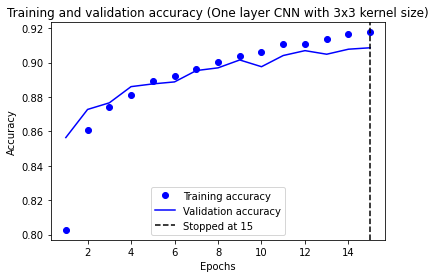

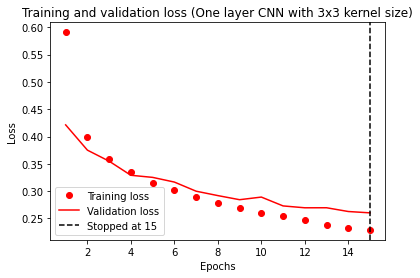

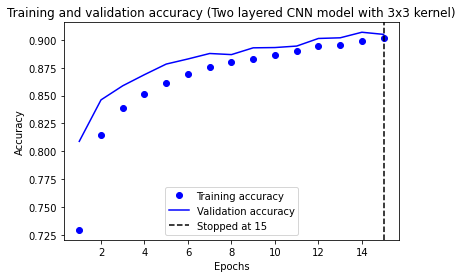

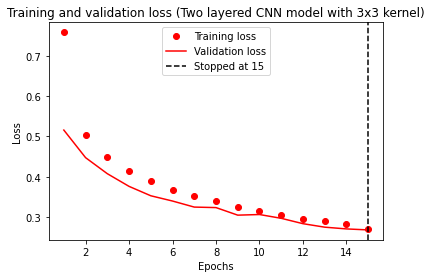

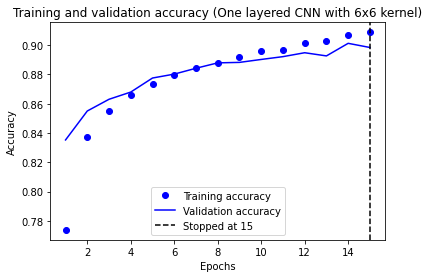

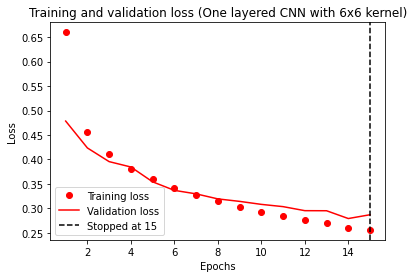

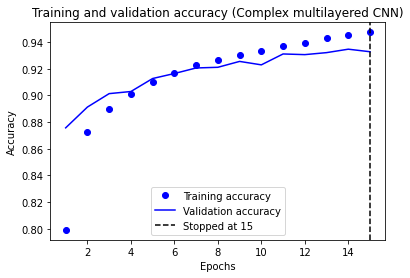

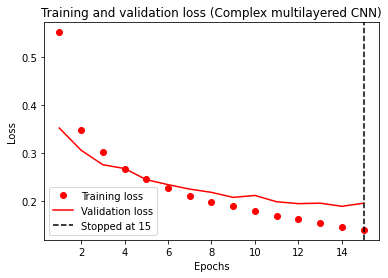

In [ ]:
for model in models:
    model.plot_history()

# Test comparison

In [ ]:
for model in models: 
    model.evaluate(test_data)

best_acc = max(models, key=lambda m: m.score[1])

313/313 [==============================] - 2s 7ms/step - loss: 0.2049 - categorical_accuracy: 0.9297


In [ ]:
print(f'Model with highest test accuracy: {best_acc.name}')
print(f'Test accuracy          = {best_acc.score[1]}')
print(f'Stopped training after = {best_acc.stopped_at} epochs')
print()

best_acc.sequential.summary()

Model with highest test accuracy: Complex multilayered CNN
Test accuracy          = 0.9297000169754028
Stopped training after = 15 epochs

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                 

In [ ]:
for model in models:
    predictions = model.sequential.predict(test_x[:5])
    print(f'Letting model {model.name} predict on 5 samples')
    print(f'Model predicted labels     = {np.argmax(predictions, axis=1)}')
    print(f'Actual labels are          = {test_labels[:5]}')
    print()

Letting model One layer CNN with 3x3 kernel size predict on 5 samples
Model predicted labels     = [9 2 1 1 6]
Actual labels are          = [9 2 1 1 6]

Letting model Two layered CNN model with 3x3 kernel predict on 5 samples
Model predicted labels     = [9 2 1 1 6]
Actual labels are          = [9 2 1 1 6]

Letting model One layered CNN with 6x6 kernel predict on 5 samples
Model predicted labels     = [9 2 1 1 6]
Actual labels are          = [9 2 1 1 6]

Letting model Complex multilayered CNN predict on 5 samples
Model predicted labels     = [9 2 1 1 6]
Actual labels are          = [9 2 1 1 6]



# Conclusion
All of the different models had relativley high test scores (+89%).
 The main differences between the models can be seen when looking at the history and how much they overfit the data. 
 Something thats interesting is how much the learning rate impacted my results.
 Befure adjusting down the learning rate from 0.001 to 0.0001, all of the graphs had the tendancy to go kinda crazy after about 6 epochs (acting like some kind of sharp sin wave), but after adjusting the learning rate they all seem to behave how I expected them to (validation and training following each other). 
 I think for this data set, the default learning rate is way too fast for my models,

Some of the models had a tendencay to more easly stagnate on their validation accuracy while the test accuracy kept raising. This can be an indication that the model is starting to overfit. 

The model that performed the best, which is no schocker really, is the "complex cnn model" which has 4 different conv layers and some additional regularization layers. 

However this model has a tendancy to also overfit. When looking at the graph over the loss, its training loss is still decreasing while the validation loss is stagnating. This could indicate that its overfitting the training data.

When looking at the graphs for all of the diffrent models, you could draw the conclusion that most of them reach a certain point where it starts to overfit at around 10 epochs. However, the two layered CNN model seems to still be on a steady course which is quite interesting. 


---

**NOTE**

I also implemented early_stopping for this laboration, however for the comparsions I did not active it because i wanted a more level playing field. I played around with early stopping for the best model i produced and it would always early stop at around 9 - 10 epochs and reset the weights here. When early stopping the model it could reach test scores of around 93-94% which was quite impressive.
